W pierwszym kroku należy załadować obraz, zmienić go na grayscale, znormalizować a potem zapisac do macierzy żeby zaczać wykonywać na nim operacje.

In [1]:
from PIL import Image
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt

def loadImage(src):
    try:
        image = Image.open(src).convert("L")
    except IOError:
        print(f"Could not find file: {src}")
        return
    imgMatrix = np.asarray(image)
    # plotting for debug purpouses
    plt.matshow(imgMatrix)
    plt.show()
    
    return imgMatrix

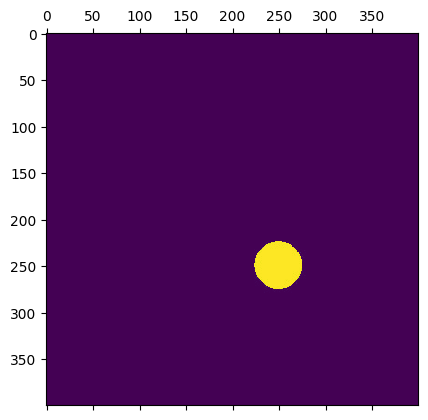

In [2]:
imgMatrix = loadImage("img/Kropka.jpg")

Następny etap to sinogram.

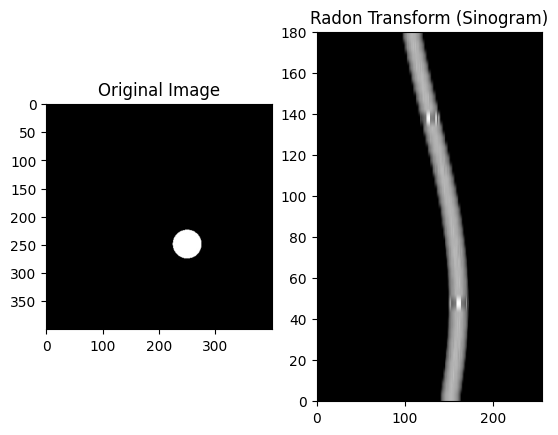

In [45]:
#obsolete
import numpy as np
import matplotlib.pyplot as plt

def radon_transform(image, theta_range, num_detectors):
    height, width = image.shape
    max_distance = int(np.ceil(np.sqrt(height**2 + width**2)))
    radon_matrix = np.zeros((len(theta_range), num_detectors))

    y, x = np.indices((height, width))
    x -= width // 2
    y -= height // 2

    theta_rad = np.deg2rad(theta_range)

    for angle_idx in range(len(theta_range)):
        ct = np.cos(theta_rad[angle_idx])
        st = np.sin(theta_rad[angle_idx])

        proj = x * ct + y * st
        proj += max_distance // 2
        proj = proj.astype(int)

        detectors = np.linspace(0, max_distance-1, num_detectors, endpoint=False, dtype=int)
        radon_matrix[angle_idx] += np.bincount(proj.ravel(), weights=image.ravel(), minlength=max_distance)[detectors]

    return np.flipud(radon_matrix)  # Flip the matrix vertically

# Example usage:
# Generate a sample image
image_size = 256
image = np.zeros((image_size, image_size))
image[image_size // 4 : 3 * image_size // 4, image_size // 4 : 3 * image_size // 4] = 1

# Set the number of detectors in the Radon matrix
num_detectors = image_size

# Set the range of angles with a step of 2 degrees
theta_range = np.arange(0, 180, 5)

# Perform Radon transform with the specified range of angles and detectors
sinogram_result = radon_transform(imgMatrix, theta_range, num_detectors)

# Display the original image and the Radon transform (sinogram)
plt.subplot(1, 2, 1)
plt.imshow(imgMatrix, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(sinogram_result, cmap='gray', extent=(0, num_detectors, 0, 180), aspect='auto')
plt.title('Radon Transform (Sinogram)')

plt.show()


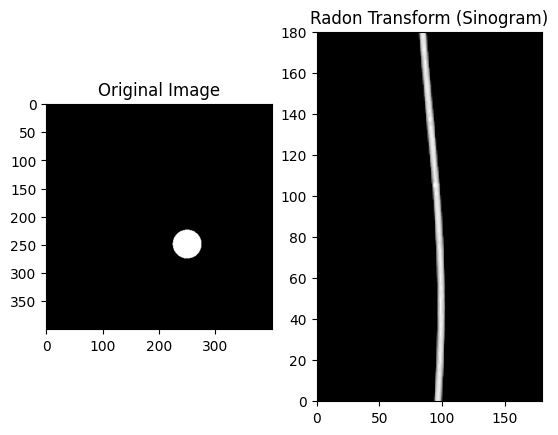

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def radon_transform(image, theta_range, num_detectors, detector_spacing):
    height, width = image.shape
    max_distance = int(np.ceil(np.sqrt(height**2 + width**2)))
    radon_matrix = np.zeros((len(theta_range), num_detectors))

    y, x = np.indices((height, width))
    x -= width // 2
    y -= height // 2

    theta_rad = np.deg2rad(theta_range)

    for angle_idx in range(len(theta_range)):
        ct = np.cos(theta_rad[angle_idx])
        st = np.sin(theta_rad[angle_idx])

        proj = x * ct + y * st
        proj += max_distance // 2
        proj = proj.astype(int)

        # Introduce detector spacing
        detectors = np.linspace(0, max_distance-1, num_detectors, endpoint=False, dtype=int)
        detector_offsets = np.linspace(-detector_spacing * (num_detectors - 1) / 2, detector_spacing * (num_detectors - 1) / 2, num_detectors)
        detectors_with_spacing = detectors + detector_offsets.astype(int)

        # Clip indices to ensure they are within bounds
        detectors_with_spacing = np.clip(detectors_with_spacing, 0, max_distance - 1)

        radon_matrix[angle_idx] += np.bincount(proj.ravel(), weights=image.ravel(), minlength=max_distance)[detectors_with_spacing]

    return np.flipud(radon_matrix)  # Flip the matrix vertically

# Example usage:
# Generate a sample image
image_size = 256
image = np.zeros((image_size, image_size))
image[image_size // 4 : 3 * image_size // 4, image_size // 4 : 3 * image_size // 4] = 1

# Set the number of detectors in the Radon matrix and detector spacing
num_detectors = 180
detector_spacing = 5  # Adjust this value to control the spacing

# Set the range of angles with a step of 2 degrees
theta_range = np.arange(0, 180, 2)

# Perform Radon transform with the specified range of angles, detectors, and spacing
sinogram_result = radon_transform(imgMatrix, theta_range, num_detectors, detector_spacing)

# Display the original image and the Radon transform (sinogram)
plt.subplot(1, 2, 1)
plt.imshow(imgMatrix, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(sinogram_result, cmap='gray', extent=(0, num_detectors, 0, 180), aspect='auto')
#plt.matshow(sinogram_result)
plt.title('Radon Transform (Sinogram)')

plt.show()
